# 5.1 Introduction to convnets

We’re about to dive into the theory of what convnets are and why they have been so
successful at computer vision tasks. But first, let’s take a practical look at a simple convnet
example. It uses a convnet to classify MNIST digits, a task we performed in chapter
2 using a densely connected network (our test accuracy then was 97.8%). Even though
the convnet will be basic, its accuracy will blow out of the water that of the densely
connected model from chapter 2.

The following lines of code show you what a basic convnet looks like. It’s a stack of
Conv2D and MaxPooling2D layers. You’ll see in a minute exactly what they do.

In [1]:
# Instantiating a small convnet
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


Importantly, a __convnet__ takes as __input__ __tensors of shape (image_height, image_width, image_channels)__ (not including the batch dimension). In this case, we’ll configure the convnet to process inputs of size (28, 28, 1), which is the format of MNIST
images. We’ll do this by passing the argument input_shape=(28, 28, 1) to the first layer.

Let’s display the architecture of the convnet so far:

In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


You can see that __the output__ of every __Conv2D__ and __MaxPooling2D layer__ is a __3D tensor__ of shape (height, width, channels). The __width and height dimensions tend to shrink as you go deeper in the network__. The __number of channels__ is __controlled by the first argument passed to the Conv2D__ layers (32 or 64).

The __next step__ is to __feed the last output tensor (of shape (3, 3, 64)) into a densely
connected classifier network__ like those you’re already familiar with: a stack of Dense
layers. These classifiers process vectors, which are 1D, whereas the current output is a
3D tensor. First __we have to flatten the 3D outputs to 1D__, and then add a few Dense layers
on top.

In [3]:
# Adding a classifier on top of the convnet
model.add(layers.Flatten()) # flat 3D to 1D
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We’ll do 10-way classification, using a final layer with 10 outputs and a softmax activation. Here’s what the network looks like now:

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

As you can see, the (3, 3, 64) outputs are flattened into vectors of shape (576,) before going through two Dense layers.
Now, let’s train the convnet on the MNIST digits. We’ll reuse a lot of the code from the MNIST example in chapter 2.

In [5]:
# Training the convnet on MNIST images
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [6]:
train_images.shape

(60000, 28, 28)

In [7]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
60000/60000 [==============================] - 59s 991us/step - loss: 0.1632 - acc: 0.9485
Epoch 2/5
60000/60000 [==============================] - 58s 963us/step - loss: 0.0452 - acc: 0.98581s - loss: 0.0
Epoch 3/5
60000/60000 [==============================] - 59s 977us/step - loss: 0.0313 - acc: 0.9907
Epoch 4/5
60000/60000 [==============================] - 58s 970us/step - loss: 0.0244 - acc: 0.9926
Epoch 5/5
60000/60000 [==============================] - 57s 953us/step - loss: 0.0190 - acc: 0.9943


Let’s evaluate the model on the test data:

In [8]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 4s 360us/step


In [9]:
test_acc

0.9917

Whereas the densely connected network from chapter 2 had a test accuracy of 98.0%,
the basic convnet has a test accuracy of 99.1%: we decreased the error rate by 68%
(relative). Not bad!

But why does this simple convnet work so well, compared to a densely connected
model? To answer this, let’s dive into what the Conv2D and MaxPooling2D layers do.

## 5.1.1 The convolution operation

The __fundamental difference__ between a __densely connected layer and a convolution
layer__ is this: __Dense layers learn global patterns__ in their input feature space (for example,
for a MNIST digit, patterns involving all pixels), whereas __convolution layers learn
local patterns__ (see figure below): in the case of images, patterns found in small 2D windows
of the inputs. In the previous example, these windows were all 3 × 3.
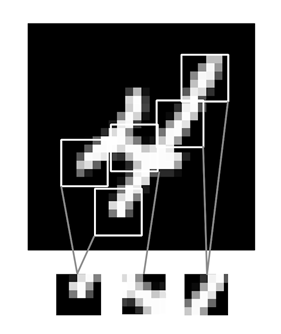

This key characteristic gives convnets two interesting properties:
* __The patterns they learn are translation invariant.__ After learning a certain pattern in the lower-right corner of a picture, a convnet can recognize it anywhere: for example, in the upper-left corner. A densely connected network would have to learn the pattern anew if it appeared at a new location. This makes convnets data efficient when processing images (because __the visual world is fundamentally translation invariant__): they need fewer training samples to learn representations that have generalization power.
* __They can learn spatial hierarchies of patterns__ (see next figure). __A first convolution layer__ will __learn small local patterns such as edges__, __a second convolution layer__ will __learn larger patterns made of the features of the first layers__, and so on. This allows convnets to efficiently learn increasingly complex and abstract visual concepts (because __the visual world is fundamentally spatially hierarchical__).

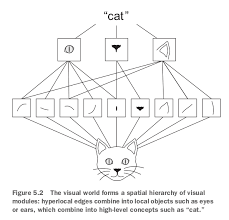

__Convolutions operate over 3D tensors__, called __feature maps__, with __two spatial axes (height and width)__ as well as a __depth axis (also called the channels axis)__. For an RGB image, the dimension of the depth axis is 3, because the image has three color hannels: red, green, and blue. For a black-and-white picture, like the MNIST digits, the depth is 1 (levels of gray). The __convolution__ operation __extracts patches__ from its input __feature map__ and __applies the same transformation__ to all of __these patches__, __producing an output feature map__. This output feature map is still a 3D tensor: it has a width and a height. Its depth can be arbitrary, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, they stand for filters. Filters encode specific aspects of the input data: at a high level, a single filter could encode the concept “presence of a face in the input,” for instance.

In the MNIST example, the first convolution layer takes a feature map of size (28, 28, 1) and outputs a feature map of size (26, 26, 32): it computes 32 filters over its input. Each of these 32 output channels contains a 26 × 26 grid of values, which is a __response map__ of the filter over the input, indicating the response of that filter pattern at different locations in the input. That is what the term __feature map__ means: every dimension in the depth axis is a feature (or filter), and the 2D tensor output[:, :, n] is the 2D spatial __map__ of the response of this filter over the input.

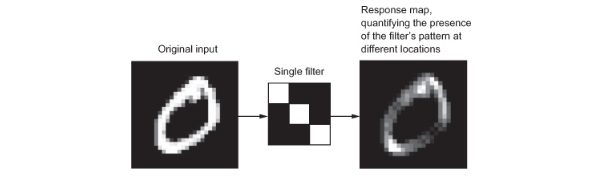

Convolutions are defined by two key parameters:
* __Size of the patches extracted from the inputs__—These are typically 3 × 3 or 5 × 5. In the example, they were 3 × 3, which is a common choice.
* __Depth of the output feature map__—The number of filters computed by the convolution. The example started with a depth of 32 and ended with a depth of 64.

In Keras __Conv2D__ layers, these parameters are the first arguments passed to the layer: 
__Conv2D(output_depth, (window_height, window_width))__.

A convolution works by __sliding__ these windows of size 3 × 3 or 5 × 5 over the 3D input feature map, stopping at every possible location, and __extracting the 3D patch of surrounding features__ (shape (window_height, window_width, input_depth)).Each such 3D patch is then transformed (via a tensor product with the same learned weight matrix, called the __convolution kernel__) into a 1D vector of shape __(output_depth,)__. All of these vectors are then spatially reassembled into a 3D output map of shape __(height, width, output_depth)__. Every spatial location in the output feature map corresponds
to the same location in the input feature map (for example, the lower-right corner of the output contains information about the lower-right corner of the input). For instance, with 3 × 3 windows, the vector output[i, j, :] comes from the 3D patch
input[i-1:i+1, j-1:j+1, :]. The full process is detailed in figure below.

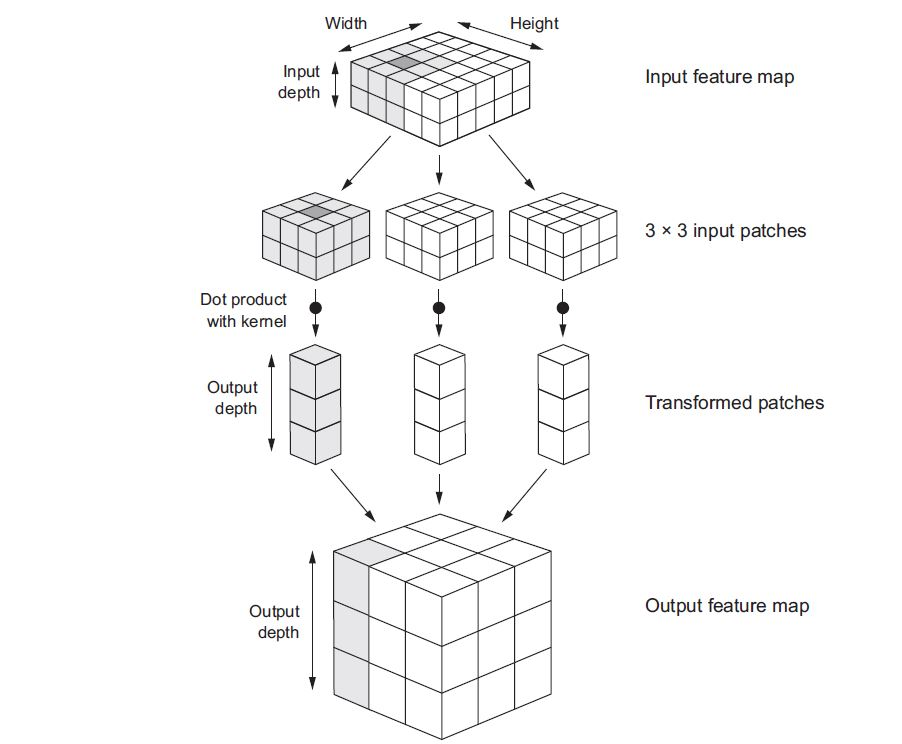

Note that the output width and height may differ from the input width and height. They may differ for two reasons:
* Border effects, which can be countered by padding the input feature map
* The use of strides, which I’ll define in a second

Let’s take a deeper look at these notions.

## UNDERSTANDING BORDER EFFECTS AND PADDING

Consider a 5 × 5 feature map (25 tiles total). There are only 9 tiles around which you can center a 3 × 3 window, forming a 3 × 3 grid. Hence, the output feature map will be 3 × 3. It shrinks a little: by exactly two tiles alongside each dimension,
in this case. You can see this border effect in action in the earlier example: you start with 28 × 28 inputs, which become 26 × 26 after the first convolution layer.

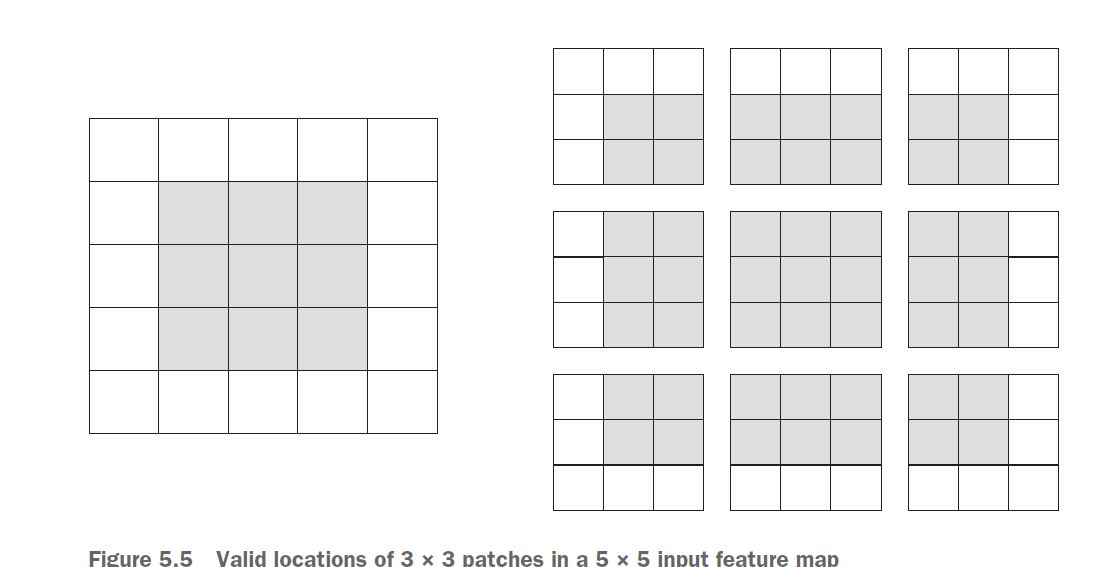

If you want to __get an output feature map__ with the __same spatial dimensions as the input__, you can __use padding__.Padding consists of adding an appropriate number of rows and columns on each side of the input feature map so as to make it possible to fit center convolution windows around every input tile.For a 3 × 3 window, you add one column on the right, one column on the left, one row at the top, and one row at the bottom. For a 5 × 5 window, you add two rows (see next figure).

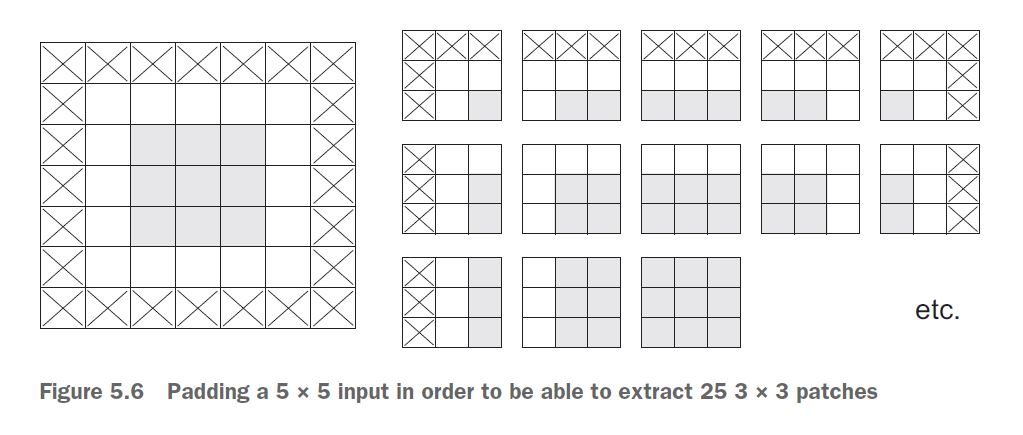

In __Conv2D__ layers, padding is configurable via the __padding__ argument, which takes two values: __"valid"__, which means __no padding__ (only valid window locations will be used); and __"same"__, which means __“pad in such a way as to have an output with the same width and height as the input.”__ The padding argument defaults to "valid".

## UNDERSTANDING CONVOLUTION STRIDES

The other factor that can influence output size is the notion of strides. The description of convolution so far has assumed that the center tiles of the convolution windows are all contiguous. But the distance between two successive windows is a parameter of the convolution, called its __stride__, which defaults to 1. It’s possible to have __strided convolutions__: convolutions with a stride higher than 1. In the next figure, you can see the patches extracted by a 3 × 3 convolution with stride 2 over a 5 × 5 input (without padding).

Using stride 2 means the width and height of the feature map are downsampled by a factor of 2 (in addition to any changes induced by border effects). Strided convolutions are rarely used in practice, although they can come in handy for some types of
models; it’s good to be familiar with the concept.

To downsample feature maps, instead of strides, we tend to use the __max-pooling__ operation, which you saw in action in the first convnet example. Let’s look at it in more depth.

## 5.1.2 The max-pooling operation

In the convnet example, you may have noticed that the __size of the feature maps__ is __halved after every MaxPooling2D layer__. For instance, before the first MaxPooling2D layers, the feature map is 26 × 26, but the max-pooling operation halves it to 13 × 13. __That’s the role of max pooling: to aggressively downsample feature maps, much like strided convolutions__.

Max pooling consists of extracting windows from the input feature maps and outputting the max value of each channel. It’s conceptually similar to convolution, except that instead of transforming local patches via a learned linear transformation (the convolution kernel), they’re transformed via a hardcoded __max__ tensor operation. A big difference from convolution is that max pooling is usually done with 2 × 2 windows and stride 2, in order to downsample the feature maps by a factor of 2. On the other hand, convolution is typically done with 3 × 3 windows and no stride (stride 1).

Why downsample feature maps this way? Why not remove the max-pooling layers and keep fairly large feature maps all the way up? Let’s look at this option. The convolutional base of the model would then look like this:

In [10]:
model_no_max_pool = models.Sequential()
model_no_max_pool.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [11]:
model_no_max_pool.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 64)        36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


What’s wrong with this setup? Two things:
* __It isn’t conducive to learning a spatial hierarchy of features__. The 3 × 3 windows in the third layer will only contain information coming from 7 × 7 windows in the initial input. The high-level patterns learned by the convnet will still be very small with regard to the initial input, which may not be enough to learn to classify digits (try recognizing a digit by only looking at it through windows that are 7 × 7 pixels!). We need the features from the last convolution layer to contain information about the totality of the input.
* The final feature map has 22 × 22 × 64 = 30,976 total coefficients per sample. __This is huge__. If you were to flatten it to stick a Dense layer of size 512 on top, that layer would have 15.8 million parameters. This is far too large for such a small model and would result in __intense overfitting__.

In short, the reason to use downsampling is to reduce the number of feature-map coefficients to process, as well as to induce spatial-filter hierarchies by making successive convolution layers look at increasingly large windows (in terms of the fraction of the original input they cover).

Note that max pooling isn’t the only way you can achieve such downsampling. As you already know, you can also use strides in the prior convolution layer. And you canuse average pooling instead of max pooling, where each local input patch is transformed
by taking the average value of each channel over the patch, rather than the max. But max pooling tends to work better than these alternative solutions. In a nutshell, the reason is that features tend to encode the spatial presence of some pattern
or concept over the different tiles of the feature map (hence, the term feature map), and __it’s more informative to look at the maximal presence of different features than at their average presence__. So the most reasonable subsampling strategy is to first produce dense maps of features (via unstrided convolutions) and then look at the maximal activation of the features over small patches, rather than looking at sparser windows of the inputs (via strided convolutions) or averaging input patches, which could cause you to miss or dilute feature-presence information.

At this point, you should understand the basics of convnets—feature maps, convolution, and max pooling—and you know how to build a small convnet to solve a toy problem such as MNIST digits classification. Now let’s move on to more useful, practical
applications.